In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
!pip install transformers==4.51.3
!pip install scikit-learn==1.6.1
!pip install pandas==2.2.2
!pip install numpy==2.0.2
!pip install matplotlib==3.10.0
!pip install seaborn==0.13.2
!pip install nltk==3.9.1
!pip install "openpyxl>=3.1.0"


In [199]:
import torch

In [200]:
import pandas as pd
import os
import glob

# 엑셀 파일들이 저장된 디렉토리 경로
folder_path = r'C:\Users\dkswo\.jupyter\sentry\labeled-1\labeled-1'

# 해당 디렉토리 내의 모든 .xlsx 파일 경로 가져오기
excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))

# 모든 엑셀 파일을 읽어서 리스트에 저장
df_list = [pd.read_excel(file) for file in excel_files]

# 하나의 DataFrame으로 병합
df = pd.concat(df_list, ignore_index=True)

In [201]:
df = df[['text', 'label']]

In [202]:
df['label'] = df['label'].apply(
    lambda x: int(x.split('_')[-1]) if isinstance(x, str) and x.startswith('LABEL_') else x
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7322 entries, 0 to 7321
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    7322 non-null   object
 1   label   7322 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 114.5+ KB


In [203]:
import sys
print(sys.version)

3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [204]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer, AutoConfig

In [ ]:
config = AutoConfig.from_pretrained(
    "alsgyu/sentiment-analysis-fine-tuned-model",
    num_labels=3,
)

In [206]:
# 모델 로드
model = AutoModelForSequenceClassification.from_pretrained(
    "alsgyu/sentiment-analysis-fine-tuned-model",
    config=config
)

In [207]:
tokenizer = AutoTokenizer.from_pretrained("alsgyu/sentiment-analysis-fine-tuned-model")

In [208]:
import transformers
print(transformers.__version__)
print(transformers.TrainingArguments.__module__)


4.51.3
transformers.training_args


In [209]:
import os
print(os.listdir())  # 현재 디렉토리 파일 목록


['data_test.ipynb', 'logs', 'results', 'test.ipynb']


In [ ]:
training_args = TrainingArguments(
    output_dir=r"C:\Users\dkswo\workspace\Project\Sentry\AI\results",
    eval_strategy="epoch",      
    save_strategy="epoch",
    learning_rate=2e-5,               
    per_device_train_batch_size=16,    
    per_device_eval_batch_size=32,
    num_train_epochs=10,               
    weight_decay=0.05,               
    save_total_limit=1,
    metric_for_best_model="f1",        # F1 기준으로 가장 좋은 모델 저장
    load_best_model_at_end=True,
    logging_dir=r"C:\Users\dkswo\workspace\Project\Sentry\AI\logs",
    greater_is_better=True,
    lr_scheduler_type="cosine",        
    warmup_ratio=0.1
)


In [211]:
def preprocess_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)


In [212]:
from sklearn.model_selection import train_test_split
from datasets import Dataset

df = df.dropna(subset=['label'])


df_train, df_valid = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=222)

train_dataset = Dataset.from_pandas(df_train)
valid_dataset = Dataset.from_pandas(df_valid)

# 확인
print("Training Dataset:", train_dataset)
print("Validation Dataset:", valid_dataset)

Training Dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 5857
})
Validation Dataset: Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1465
})


In [213]:
# 토큰화 적용
train_dataset = train_dataset.map(preprocess_function, batched=True)
valid_dataset = valid_dataset.map(preprocess_function, batched=True)

# 불필요한 열 제거
train_dataset = train_dataset.remove_columns(["text"])
valid_dataset = valid_dataset.remove_columns(["text"])

# 확인
print("Tokenized Training Dataset:", train_dataset)
print("Tokenized Validation Dataset:", valid_dataset)

Map: 100%|██████████| 1465/1465 [00:00<00:00, 8971.57 examples/s]

Tokenized Training Dataset: Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 5857
})
Tokenized Validation Dataset: Dataset({
    features: ['label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1465
})


In [214]:
label_counts = df['label'].value_counts()

print(label_counts)

label
2    4228
1    1653
0    1441
Name: count, dtype: int64


In [215]:
import torch
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# 클래스 라벨과 개수
class_labels = np.array([0, 1, 2])  # 리스트 → 넘파이 배열
class_counts = [1441, 1653, 4228]

# y 생성
y = [label for label, count in zip(class_labels, class_counts) for _ in range(count)]

# 클래스 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=y)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

In [216]:
# 커스텀 트레이너 정의
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_fn = nn.CrossEntropyLoss(weight=self.class_weights.to(self.args.device))
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [217]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import EarlyStoppingCallback

# 평가 지표 함수
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Trainer 정의
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)], # earlystopping callback 추가
    class_weights=class_weights_tensor
)

C:\Users\dkswo\AppData\Local\Temp\ipykernel_14728\1632347034.py:7: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [218]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.494051,0.783618,0.790701,0.819821,0.783618
2,0.628700,0.431102,0.849829,0.851149,0.854695,0.849829
3,0.367600,0.478466,0.858703,0.860089,0.862525,0.858703
4,0.367600,0.608959,0.858703,0.859773,0.861751,0.858703
5,0.191500,0.812130,0.861433,0.861155,0.861716,0.861433
6,0.093800,0.925922,0.861433,0.860832,0.861090,0.861433
7,0.055400,0.966992,0.855973,0.857174,0.859429,0.855973


TrainOutput(global_step=2569, training_loss=0.26112992367237725, metrics={'train_runtime': 533.9592, 'train_samples_per_second': 131.628, 'train_steps_per_second': 8.248, 'total_flos': 6320734578181800.0, 'train_loss': 0.26112992367237725, 'epoch': 7.0})

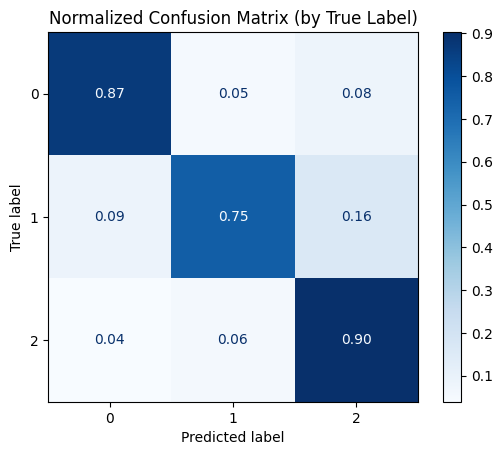

In [220]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측값 얻기
predictions = trainer.predict(valid_dataset)
y_true = predictions.label_ids
y_pred = predictions.predictions.argmax(-1)

# 정규화된 Confusion Matrix (True Label 기준 → 행 기준 비율)
cm = confusion_matrix(y_true, y_pred, normalize='true')

# 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format=".2f")  # 소수점 2자리로 출력
plt.title("Normalized Confusion Matrix (by True Label)")
plt.show()


c:\Users\dkswo\anaconda3\envs\condatest\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49457 (\N{HANGUL SYLLABLE SEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dkswo\anaconda3\envs\condatest\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45733 (\N{HANGUL SYLLABLE NEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dkswo\anaconda3\envs\condatest\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dkswo\anaconda3\envs\condatest\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\dkswo\anaconda3\envs\condatest\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45944 (\N{HANG

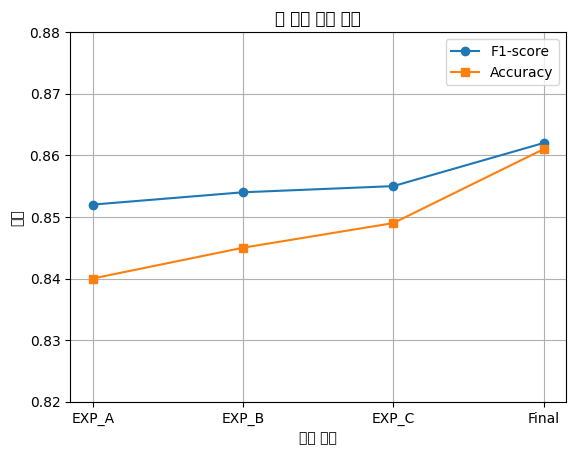

In [ ]:
import matplotlib.pyplot as plt

# 실험 버전별 성능 (예시 데이터)
versions = ["EXP_A", "EXP_B", "EXP_C", "Final"]
f1_scores = [0.852, 0.854, 0.855, 0.862]
accuracy = [0.840, 0.845, 0.849, 0.861]

plt.plot(versions, f1_scores, marker='o', label="F1-score")
plt.plot(versions, accuracy, marker='s', label="Accuracy")
plt.ylim(0.82, 0.88)
plt.title("모델 성능 비교")
plt.xlabel("실험 버전")
plt.ylabel("성능")
plt.grid(True)
plt.legend()
plt.show()
